Your task is to use the Hotel Reservation dataset to explore the outcomes of the CART algorithm for predicting whether a reservation will be canceled.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [35]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay

1. Read the Hotel Reservation data set  into a data frame. 
2. For the set of predictors, select the columns 'required_car_parking_space', 'lead_time', 'repeated_guest', 'avg_price_per_room' and those whose name starts with 'no_of_'. For the target variable,  map column 'booking_status' values to 1 for 'Canceled' and 0 for 'Not Canceled'.

In [36]:
import sklearn
sklearn.__version__

'1.3.0'

In [63]:
np.__version__

'1.24.3'

In [37]:
df = pd.read_csv("./HotelReservations.csv")

In [38]:
cols = ['required_car_parking_space','lead_time','repeated_guest','avg_price_per_room'] + \
    [col for col in df.columns if col.startswith('no_of_')]
print(cols)

['required_car_parking_space', 'lead_time', 'repeated_guest', 'avg_price_per_room', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']


In [39]:
df.booking_status= df['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

In [40]:
X = df[cols]
y = df['booking_status']

3. Define a simple decision tree classifier with max_depth = 5. Check which split criterion is set by default. 

In [41]:
tree = DecisionTreeClassifier(max_depth=5)
tree.criterion

'gini'

4. Define a train/test split of the data set  with a test size equal to 30%. Hint: use the function 'train_test_split()'. Fit the decision tree classifier to the training data and evaluate its accuracy on the test data. Hint: use the functions ‘fit()’, ‘predict()’ and  ‘accuracy_score()’.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [43]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [44]:
# print("Accuracy = ",tree.score(X_test,y_test))
y_pred = tree.predict(X_test)
print("Accuracy = ",accuracy_score(y_test,y_pred))

Accuracy =  0.8080492511256088


In [45]:
def myplot_tree(tree,X,y,class_names=['not canceled','canceled']):
    # Export decision tree to DOT format
    dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X.columns,  
                           class_names=class_names,
                           filled=True, rounded=True,  
                           special_characters=True)

    # Plot decision tree
    graph = graphviz.Source(dot_data)
    graph.render("decision_tree")  # save to file
    graph.view()  # open in viewer

In [46]:
myplot_tree(tree,X_train,y_train)

5. Define a function that displays the confusion matrix and the accuracy, given a fitted model, the predictors and the target of the test set, Hint: use the functions 'confusion_matrix()' and 'ConfusionMatrixDisplay()'.


Accuracy =  0.8080492511256088


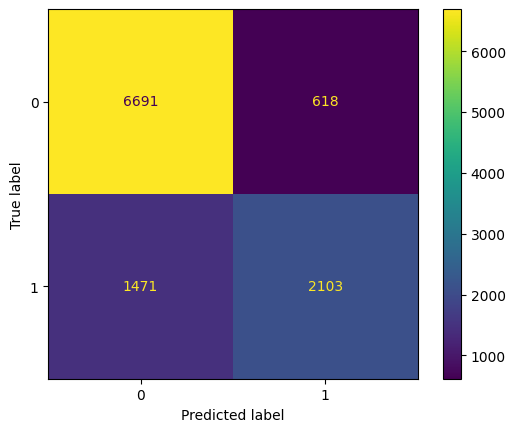

In [47]:
def plot_cm(model_fit,X_test,y_test):
    y_pred = model_fit.predict(X_test)
    print("Accuracy = ",accuracy_score(y_test,y_pred))
    cm =  confusion_matrix(y_test, y_pred)
    # ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model_fit.classes_)
    disp.plot()
    
plot_cm(tree,X_test,y_test)

6. Define a function that plots the ROC curve and respective AUC, given a fitted model, the predictors and the target of the test set. Hint: use the functions ‘predict_proba()’, ‘roc_curve()’ and ‘roc_auc_score()’.


In [48]:
y_pred_prob = tree.predict_proba(X_test)
#print(y_pred_prob)

In [60]:
def plot_roc_curve(model_fit,X_test,y_test):
    y_pred_prob = model_fit.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob[:,1])
    auc = roc_auc_score(y_test, y_pred_prob[:,1])
    
    #create ROC curve
    plt.plot(fpr,tpr, label="AUC="+str(round(auc,3)))
    plt.plot(np.linspace(0,1,5),np.linspace(0,1,5),linestyle='--',linewidth=0.5,color="grey")
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

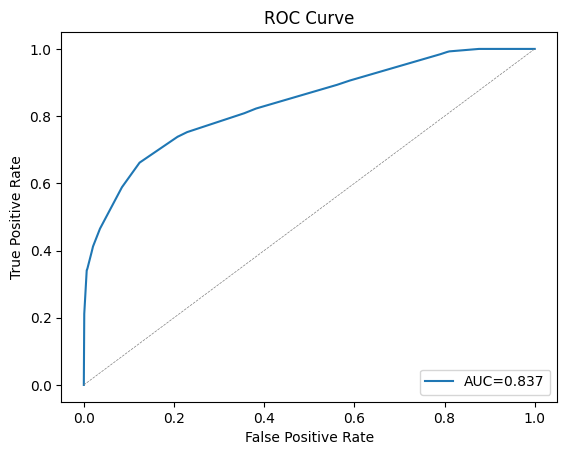

In [61]:
plot_roc_curve(tree,X_test,y_test)

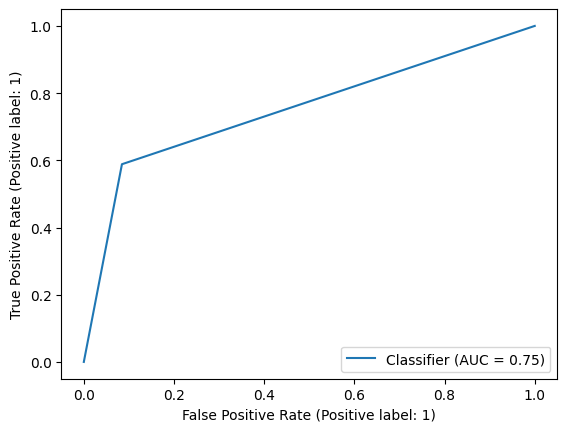

In [64]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [68]:
roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])

0.8369014315165785

7. Define a function ‘holdout_estimation()’ that receives an unfitted model, the set of predictors, the target, and the size of the test partition and returns the accuracy estimate.


In [19]:
def holdout_estimation(model,X,y,test_size=0.3,seed=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("Estimated accuracy by holdout (",test_size,")= ",round(accuracy_score(y_test,y_pred),3))

In [20]:
holdout_estimation(tree,X,y)

Estimated accuracy by holdout ( 0.3 )=  0.808


8. Define a function ‘cv_estimation()’ that receives an unfitted model, the set of predictors, the target, and the number of k for the k-fold cv and returns the accuracy estimate (mean and standard deviation). Hint: If you don’t want to obtain all the partitions for training/testing, you can use the function ‘cross_val_score()’.


In [21]:
def cv_estimation(model,X,y,k=10):
    accuracy_cv = cross_val_score(model, X, y, cv=k)
    print("Estimated accuracy by ",k,"- cv = ",round(accuracy_cv.mean(),3),"+/-",round(accuracy_cv.std(),3))

In [22]:
cv_estimation(tree,X,y)

Estimated accuracy by  10 - cv =  0.811 +/- 0.006


9. Train decision trees with different values for the hyperparameters max_depth, min_samples_split, min_samples_leaf, and min_impurity_decrease. Analyze how that impacts the fitted model's performance by holdout and cross-validation.


In [23]:
new_tree = DecisionTreeClassifier(max_depth=20)
holdout_estimation(new_tree,X,y)
cv_estimation(new_tree,X,y)

Estimated accuracy by holdout ( 0.3 )=  0.844
Estimated accuracy by  10 - cv =  0.853 +/- 0.005


In [24]:
new_tree = DecisionTreeClassifier(max_depth=20,min_samples_split=5)
holdout_estimation(new_tree,X,y)
cv_estimation(new_tree,X,y)

Estimated accuracy by holdout ( 0.3 )=  0.843
Estimated accuracy by  10 - cv =  0.852 +/- 0.005


In [27]:
new_tree = DecisionTreeClassifier(max_depth=20,min_impurity_decrease=0.01)
holdout_estimation(new_tree,X,y)
cv_estimation(new_tree,X,y)

Estimated accuracy by holdout ( 0.3 )=  0.767
Estimated accuracy by  10 - cv =  0.77 +/- 0.007


10. For a decision tree with a max_depth of 20, consider that partitions of increasing size (e.g. from 10% to 100%, with steps of 10%) are given for training the model with the remaining partition for testing. Check how the performance on the train and the test sets evolves. Hint: use the function learning_curve() that determines cross-validated training and test scores for different training set sizes.

In [28]:
# Define the learning curve function
def plot_learning_curves(model, X, y,title=''):
    
    tr_size = np.linspace(0.1,1.0,10)
    #tr_size = [0.3,0.7,0.9]
    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, 
                                                            scoring='accuracy', 
                                                            train_sizes=tr_size)
    
    for tr_size, cv_tr_score, cv_ts_score in zip(train_sizes,train_scores,test_scores):
        print("Train size:",tr_size,"Train score:",round(cv_tr_score.mean(),3),"Test score:",round(cv_ts_score.mean(),3))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(train_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Test score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()

Train size: 2902 Train score: 0.904 Test score: 0.804
Train size: 5804 Train score: 0.883 Test score: 0.816
Train size: 8706 Train score: 0.873 Test score: 0.824
Train size: 11608 Train score: 0.867 Test score: 0.829
Train size: 14510 Train score: 0.865 Test score: 0.836
Train size: 17412 Train score: 0.864 Test score: 0.835
Train size: 20314 Train score: 0.862 Test score: 0.84
Train size: 23216 Train score: 0.862 Test score: 0.841
Train size: 26118 Train score: 0.859 Test score: 0.84
Train size: 29020 Train score: 0.857 Test score: 0.841


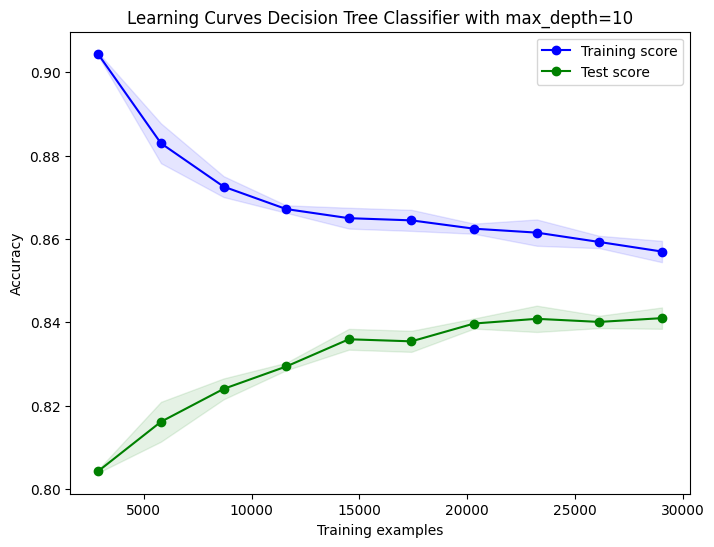

Train size: 2902 Train score: 0.988 Test score: 0.788
Train size: 5804 Train score: 0.987 Test score: 0.803
Train size: 8706 Train score: 0.981 Test score: 0.814
Train size: 11608 Train score: 0.972 Test score: 0.825
Train size: 14510 Train score: 0.971 Test score: 0.827
Train size: 17412 Train score: 0.968 Test score: 0.836
Train size: 20314 Train score: 0.967 Test score: 0.841
Train size: 23216 Train score: 0.968 Test score: 0.841
Train size: 26118 Train score: 0.965 Test score: 0.845
Train size: 29020 Train score: 0.962 Test score: 0.849


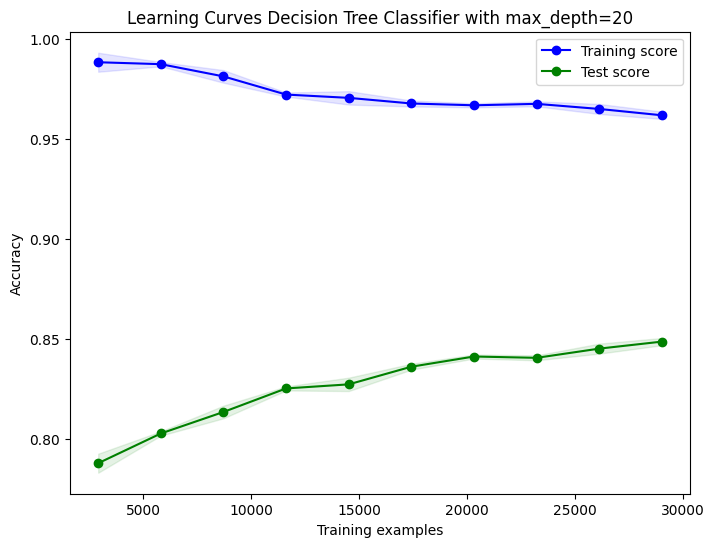

In [29]:
for max_depth in [10,20]:
    tree_d = DecisionTreeClassifier(max_depth=max_depth)
    plot_learning_curves(tree_d,X,y,title='Decision Tree Classifier with max_depth='+str(max_depth))